In [2]:
# System setup (install necessary packages only once)
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.tom

In [3]:
import os
import torch
import matplotlib.pyplot as plt

from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model


In [5]:
 # ✅ Step 2: Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [11]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [12]:
import zipfile
import os

zip_path = '/content/drive/My Drive/dataa/train_test_data.zip'
extract_path = '/content/train_test_data'  # You can change this folder if you want

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction done!")

# Step 3: List extracted files to verify
extracted_files = os.listdir(extract_path)
print("Extracted files:")
for file in extracted_files:
    print(file)

Extraction done!
Extracted files:
test
train
dataset_dict.json


In [13]:
from datasets import load_from_disk

# Load the dataset
dataset = load_from_disk("/content/train_test_data")

# Split into training and evaluation sets
train_dataset = dataset['train']
eval_dataset = dataset['test']

# Optional: peek at a few examples
print("Train example:", train_dataset[0])
print("Eval example:", eval_dataset[0])


Train example: {'instruction': "If you are a doctor, please answer the medical questions based on the patient's description.", 'input': 'My grand daughter just came from her OB and they said that she definitely was pregnant, but now it is detaching from the uterus. She has slight cramping; nothing major, no bleeding. She was given a prescription for suppositories to induce the D&C affect. Should she take these without any other symptoms present at this time?', 'output': "Respected user, thanks for using Chat Doctor.come have evaluated your query thoroughly.* Cramps during pregnancy may be due to - non-specific cause - uterine expansion via growing fetus - placental separation - fetal movements related - other abdominal causes * Only pain is not the criteria for induction of D&C effect, there are many parameters gone doctor evaluate and then decide for the prescription.* I strongly recommend following strictly your doctor's advise only. Hope to clarify your query. Welcome for further as

In [14]:
def formatting_func(example):
    return f"### The following is a doctor's opinion on a patient's query:\n### Patient query: {example['input']}\n### Doctor opinion: {example['output']}"

print(formatting_func(train_dataset[0]))


### The following is a doctor's opinion on a patient's query:
### Patient query: My grand daughter just came from her OB and they said that she definitely was pregnant, but now it is detaching from the uterus. She has slight cramping; nothing major, no bleeding. She was given a prescription for suppositories to induce the D&C affect. Should she take these without any other symptoms present at this time?
### Doctor opinion: Respected user, thanks for using Chat Doctor.come have evaluated your query thoroughly.* Cramps during pregnancy may be due to - non-specific cause - uterine expansion via growing fetus - placental separation - fetal movements related - other abdominal causes * Only pain is not the criteria for induction of D&C effect, there are many parameters gone doctor evaluate and then decide for the prescription.* I strongly recommend following strictly your doctor's advise only. Hope to clarify your query. Welcome for further assistance. Thanks for using Chat Doctor .com & giv

In [15]:
base_model_id = "tiiuae/falcon-7b-instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,
    device_map="auto"
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id)
tokenizer.pad_token = tokenizer.eos_token


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [16]:
max_length = 512

def generate_and_tokenize_prompt(example):
    tokenized = tokenizer(
        formatting_func(example),
        truncation=True,
        max_length=max_length,
        padding="max_length"
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

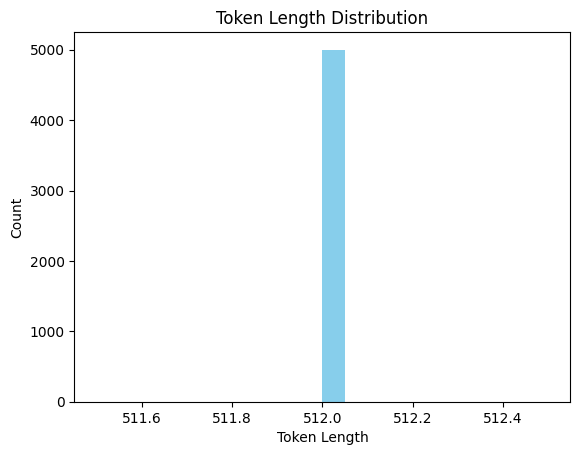

In [17]:
def plot_data_lengths(train_data, val_data):
    lengths = [len(x['input_ids']) for x in train_data] + [len(x['input_ids']) for x in val_data]
    plt.hist(lengths, bins=20, color='skyblue')
    plt.xlabel('Token Length')
    plt.ylabel('Count')
    plt.title('Token Length Distribution')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)


In [18]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["query_key_value", "dense", "dense_h_to_4h", "dense_4h_to_h"],  # Falcon-specific
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)


In [22]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir="./falcon-patient-chatbot",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    eval_steps=100,
    save_steps=100,
    logging_steps=100,
    learning_rate=2e-4,
    max_steps=500,
    save_total_limit=2,
    report_to="none",
    logging_dir="./logs"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()


No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


KeyboardInterrupt: 